# Unsupervised Learning Algorithms

In this notebook, the clustering methods explained in \[1\] can be found. This
work was done for the subject Artificial Intelligence, by Juan Sebastián
Cárdenas Rodríguez of the Universidad EAFIT.

This notebook was tested with `julia 1.5.1`.

### References
\[1\]: Moertini, V. "Introduction to Five Data Clustering Algorithm." Integral
7, no. 2 (2002): 87-96.

\[2\]: Chiu, Stephen L. "Fuzzy model identification based on cluster
estimation." Journal of Intelligent & fuzzy systems 2, no. 3 (1994): 267-278.

## Dependencies
The version for each dependency is
- `Colors 0.12.4`
- `Distributions 0.23.10`
- `Plots 1.6.0`
- `RDatasets 0.6.10`
- `Statsbase 0.33.1`

To install the latest versions for this dependencies, execute the following
cell.

In [ ]:
using Pkg

Pkg.add(name = "Clustering", version = "0.14.1")
Pkg.add(name = "Colors", version = "0.12.4")
Pkg.add(name = "Distributions", version = "0.23.10")
Pkg.add(name = "Plots", version = "1.6.0")
Pkg.add(name = "RDatasets", version = "0.6.10")
Pkg.add(name = "StatsBase", version = "0.33.1")


Global packages and behavior.

In [147]:
using Clustering
using Colors
using Distributions
using Plots
using Random
using RDatasets
using StatsBase

default(show = true)


## Norm Functions
In this section you will find an implementation for different norm functions.
Each of the norm functions have the following parameters:

- `data` which is a matrix of size *nxm*, with _n_ being the number of data
  points and _m_ the number of dimensions that the data point has.
- `center` is a vector of size _m_.
- `norm` determines if the norm or the distance is calculated.

If `norm` is `true` the norm of the subtraction of each row of `data` and
`center` will be calculated. Otherwise, the distance between the same data
points will be calculated. Other parameters are dependent on the norm function
applied and will be explained in each cell.


In [135]:
function euclidean(data, center; norm = false)
    center_aux = reshape(center, 1, length(center))
    diff = data .- center_aux
    value = sum(diff .^ 2, dims = 2)
    if norm
        return value
    end

    return sqrt.(value)
end;


In [134]:
function manhattan(data, center; norm = false)
    center_aux = reshape(center, 1, length(center))
    diff = data .- center_aux
    if norm
        return abs.(diff) .^ 2
    end

    return abs.(diff)
end;


In [137]:
function mahalanobis(data, center, IS; norm = false)
    diff = data .- center_aux
    aux = (diff * IS) .* diff
    if norm
        return sum(aux, dims = 2)
    end

    return sqrt.(sum(aux, dims = 2))
end;


## Clustering Algorithms

In this section the clustering methods, with some useful additional methods can
be found.

The function `find_membership` receives the parameters:
- `data` which is a matrix of size *nxm*.
- `dist` is a function that evaluates a distance function for a given data set
  and center.
- `prototypes` is a matrix of size *kxm* with *k* being the number of prototypes
  that clusterize the data set.
- `args` are the extra required arguments that the distance method needs to run.

It returns a matrix `u` of size *kxn* that shows to which group a certain data
point belongs. This is done by selecting the prototype for which it is closer.
Lastly, the function returns a matrix of `distances` of size *kxn* of each
prototype to each data point.


In [5]:
function find_membership(data, dist, prototypes, args)
    k = size(prototypes)[1]
    u = zeros(Float64, k, size(data)[1])
    distances = zeros(Float64, k, size(data)[1])
    for j in 1:k
        distances[j, :] = dist(data, prototypes[j, :], args...)
    end
    indexes_min = argmin(distances, dims = 1)
    u[indexes_min] .= 1

    return u, distances
end;


The function `normalize` has one input that is `data` which is a matrix *nxm*.
This function returns the data normalized, dividing by the maximum value in each
dimension.


In [6]:
function normalize(data)
    factor = maximum(abs.(data), dims = 1)
    return data ./ factor
end;


The function `plot_clusters` plots a data set colorized by the different
clusters of each group. It recieves:
- `proto` which is a matrix of size *kxm* that contains each of the centroids
  for each group.
- `memberships` is a matrix of size *kxn* that contains to which of the groups a
  data point belongs.
- `data` is a matrix of size *nxm* that contains the data set.
- `pos` is a symbol that has the position of the labels in the plot.

In [81]:
function plot_clusters(proto, memberships, data, pos)
    xs = []
    ys = []
    labels = []
    for j in 1:size(proto)[1]
        data_aux = data[findall(x -> x == 1, memberships[j, :]), :]
        push!(xs, data_aux[:, 1])
        push!(ys, data_aux[:, 2])
        push!(labels, string("Group ", j))
    end
    push!(xs, protos[:, 1])
    push!(ys, protos[:, 2])
    push!(labels, "Centers")
    labels = reshape(labels, 1, :)
    scatter(xs, ys,
            fmt = :png,
            label = labels,
            legend = pos,
            markersize = 5,
            markerstrokewidth=0,
            palette=:darkrainbow,
            xlabel = "x",
            ylabel = "y")
end;


The function `plot_clusters3d` haves a similar behavior to the function defined
above, but for 3d data. The aditional parameter `camera` is a tuple that
represent the azimuth and altitude for which the plot is shown.


In [82]:
function plot_clusters3d(proto, memberships, data, pos, camera, xlabel, ylabel, zlabel)
    xs = []
    ys = []
    zs = []
    labels = []
    for j in 1:size(proto)[1]
        data_aux = data[findall(x -> x == 1, memberships[j, :]), :]
        push!(xs, data_aux[:, 1])
        push!(ys, data_aux[:, 2])
        push!(zs, data_aux[:, 3])
        push!(labels, string("Group ", j))
    end
    push!(xs, protos[:, 1])
    push!(ys, protos[:, 2])
    push!(zs, protos[:, 3])
    push!(labels, "Centers")
    labels = reshape(labels, 1, :)
    scatter(xs, ys, zs,
            fmt = :png,
            label = labels,
            legend = pos,
            markersize = 5,
            markerstrokewidth=0,
            palette=:darkrainbow,
            camera = camera,
            xlabel = xlabel,
            ylabel = ylabel,
            zlabel = zlabel)
end;

The function `meshgrid` partitions the domain for each variable of a data set,
in order to form a grid of size *n* in each dimension. This function returns an
array, similar to the data set, which each of the points in the grid.


In [8]:
function meshgrid(data, n)
    mins = minimum(data, dims = 1)
    maxs = maximum(data, dims = 1)
    ranges = [mins[j]:(maxs[j] - mins[j])/n:maxs[j] for j in 1:length(mins)]

    # Grid generation
    grid = reshape(collect(Iterators.product(ranges...)), 1, :)

    # Array creation
    array = vcat(map(x -> transpose(collect(x)), grid)...)

    return array
end;

### Hard Clustering
In this section, the method for k-means and fuzzy c-means explained in the
article mentioned can be found.

In first place, the function `cost` calculates the cost function. The parameters
for this method are a membership matrix `u` and a distances matrix called
`distances`.


In [9]:
function cost(u, distances)
    return sum((distances .* u))
end;


The function `k_means` does the k-means algorithm for a given data set. The parameters of this function are
- `data` which is a matrix of size *nxm*.
- `k` is the number of clusters to separate the dataset.
- `dist` is a function that evaluates a distance function for a given data set and center.
- `args` are the extra required arguments that the distance method needs to run.

In [10]:
function k_means(data, k, dist, tol, args...)
    indexes = collect(1:size(data)[1])
    selection = sample(indexes, k, replace = false)
    prototypes = data[selection, :]
    cost_prev = 0
    first = true
    while true
        u, distances = find_membership(data, dist, prototypes, args)
        cost_now = cost(u, distances)
        if first
            first = false
        elseif abs(cost_now - cost_prev) < tol
            break
        end
        cost_prev = cost_now
        prototypes = (u * data) ./ sum(u, dims = 2)
    end

    u, _ = find_membership(data, dist, prototypes, args)
    return prototypes, u
end;


The function `fuzzy_c_means` runs the fuzzy c-means algorithm for a given data
set. The parameters are similar to the ones in `k_means` with a new parameter
`m` which is the weighting exponent.


In [11]:
function fuzzy_c_means(data, c, m, dist, tol, args...)
    u = Random.rand(Float64, (c, size(data)[1]))
    u = u ./ sum(u, dims = 1)
    prototypes = u .^ m * data ./ sum(u .^ m, dims = 2)
    cost_prev = 0
    first = true
    while true
        _, distances = find_membership(data, dist, prototypes, args)
        cost_now = cost(u .^ m, distances)
        if first
            first = false
        elseif abs(cost_now - cost_prev) < tol
            break
        end
        cost_prev = cost_now

        for i in 1:size(u)[1]
            for j in 1:size(u)[2]
                u[i, j] = 1 / sum((distances[i, j] ./ distances[:, j]) .^ (2 / (m - 1)))
            end
        end
        power_u = u .^ m
        prototypes = power_u * data ./ sum(power_u, dims = 2)
    end

    return prototypes
end;


### Soft Clustering
In this section the montain and subtractve clustering functions are done.

In first place, the function `get_prototypes` extracts the prototypes from a
list of `indexes` and a matrix with possible `centers`.

In [12]:
function get_prototypes(indexes, centers)
    prototypes = hcat(map(x -> centers[x, :], indexes)...)
    return collect(transpose(prototypes))
end;


The function `montain_function` is a method use to calculate the density of a
point. Furthermore, this function is usable in other contexts, that provide
versatility to calculating the densities in the soft clustering methods.

The parameters are:
- `data` which is a matrix that denotes the data for which the distance will be
calculated.
- `centers` which is a matrix or a vector. If a matrix is given, the density for
each row is calculated. On the other hand, the density for each row of data is
given.
- `dist` is a function that calculates the distance.
- `sigma` is a value that standarizes the distances.
- `args` is a list that contains the extra arguments needed to run the distance
function.

In [13]:
function montain_function(data, centers, dist, sigma, args)
    if isa(centers, Vector)
        distances = dist(data, centers, args..., norm = true)[:, 1]
        m = exp.(-distances ./ (2 * sigma^2))
    else
        m = zeros(Float64, size(centers)[1])
        for i in 1:size(centers)[1]
            distances = dist(data, centers[i, :], args..., norm = true)
            m[i] = sum(exp.(-distances ./ (2 * sigma^2)))
        end
    end
    return m
end;


The function `abstract_clustering` is a proxy for executing the montain and
substractive clustering methods. This function clusters given a density
function and an option of centers. Furthermore, the condition for the
convergence of the algorithm was programmed following the one purposed by \[2\].

The parameters for the function are:
- `data` which is a matrix that denotes the data for which the distance will be
calculated.
- `centers` which is a matrix that contains a candidate for a prototype.
- `dist` is a function that calculates the distance.
- `sigma` and `beta` are values that standarizes the distances.
- `tol` and `tol1` are, respectively, the upper and lower threshold defined in
the article.
- `args` are the extra arguments needed to run the distance function.


In [14]:
function abstract_clustering(data, centers, dist, sigma, beta, tol, tol1, args)
    indexes = []
    montain_values = montain_function(data, centers, dist, sigma, args)

    # First selection
    push!(indexes, argmax(montain_values))
    montain_first = montain_values[indexes[end]]
    testing = false

    # Select other centers
    while true
        if !testing
            # Update montain function
            prev_center = centers[indexes[end], :]
            montain_to_center = montain_function(centers, prev_center, dist, beta, args)
            old_montain = montain_values[indexes[end]]
            montain_values -= old_montain * montain_to_center
        end

        push!(indexes, argmax(montain_values))

        # Convergence by Chiu
        ratio = montain_values[indexes[end]] / montain_first
        if ratio > tol
            continue
        elseif ratio < tol1
            indexes = indexes[1:(length(indexes) - 1)]
            break
        else
            last_index = length(indexes) - 1
            protos = get_prototypes(indexes[1:last_index], centers)
            distances = dist(protos, centers[indexes[end], :], args...)
            min_dist = minimum(distances)

            if min_dist / (2 * sigma) + ratio < 1
                montain_values[indexes[end]] = 0
                indexes = indexes[1:(length(indexes) - 1)]
                testing = true
                continue
            end
        end

        testing = false

    end

    return get_prototypes(indexes, centers)
end;


In this cell both the `montain_clustering` and `subtractive_clustering` can be
found. As it is seen, both of this algorithms run a proxy method.

This was done to simplify code, as the only real difference between both methods
are the options for the prototypes. Furthermore, each parameter `sigma` and
`beta` have a correspondence with the parameters `ra` and `rb`.


In [92]:
function montain_clustering(data, n, dist, sigma, beta, tol, tol1, args...)
    centers = meshgrid(data, n)

    return abstract_clustering(data, centers, dist, sigma, beta, tol, tol1, args)
end;

function subtractive_clustering(data, dist, ra, rb, tol, tol1, args...)
    return abstract_clustering(data, data, dist, ra / 2, rb / 2, tol, tol1, args)
end;


## Testing Methods
For testing each method, the upper and lower threshold was used as recommended
by the original article of 0.5 and 0.15 respectively for the soft clustering
methods.

Lastly, it is important to notice that the author did not find any
implementations for the soft clustering algorithms already done in `julia`.
Hence, a comparison will not be made for this functions.

### Gaussian Mixture
For this section, a gaussian mixture was created to test that each method works
for a simple separation. Furthermore, it allowed to found errors for the code
and it is deemed by the author with enough value to show.

The `create_mixture` function creates a mixture of gaussian variables with
different means and same covariance.


In [16]:
function create_mixture(n_of_mixtures, size_of_data; mean_change=1)
    # Initial values for generation
    μ = [1, 1]
    Σ = Matrix{Float64}([1 0; 0 1])
    data = zeros(Float64, 2, size_of_data)

    # Generate first sample
    Random.rand!(MvNormal(μ, Σ), data)

    # Generate other samples
    for j in 2:n_of_mixtures
        μ = μ .+ mean_change
        aux = zeros(Float64, 2, size_of_data)
        Random.rand!(MvNormal(μ, Σ), aux)

        data = [data aux]
    end

    return collect(transpose(data))
end;


**Data Creation**

In [56]:
data = create_mixture(4, 1000, mean_change=10);


**K-means**

One important thing to notice surrounding this method is that, for some initial
configuration of the prototypes, the algorithm does not converge to a solution.
This occurs precisely when two of the initial prototypes land in the same group,
hence not progressing through other gropus as their mean stabilizes in the same
gaussian cluster.


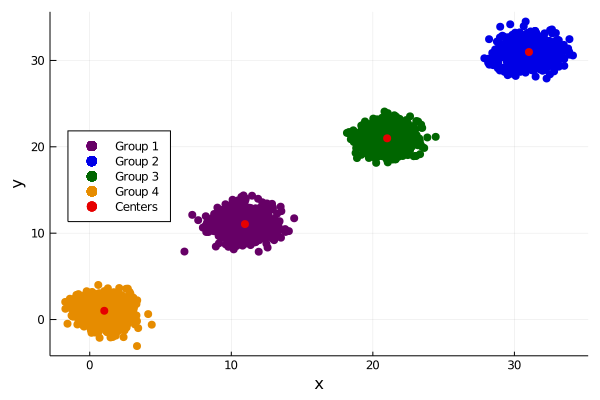

In [162]:
protos, u = k_means(data, 4, euclidean, 1e-8)
plot_clusters(protos, u, data, :left)


Comparing with the implementation in Julia, it is seen that the solutions are
pretty much the same. On the other hand, the library does not have the error
that the previous algorithm presents. This is seen as the library does not
select random prototypes.


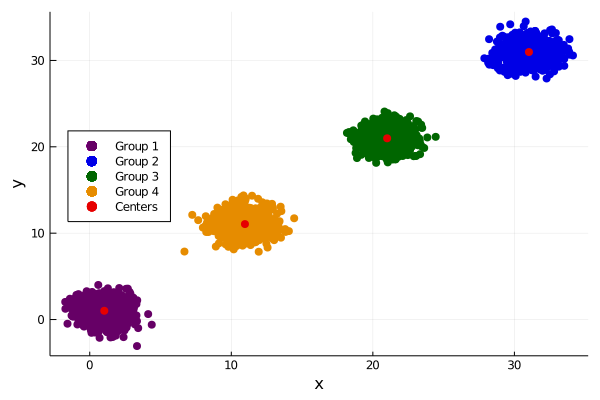

In [170]:
protos_lib = transpose(Clustering.kmeans(transpose(data), 4).centers)
u, _ = find_membership(data, euclidean, protos_lib, [])
plot_clusters(protos_lib, u, data, :left)


**Fuzzy C-means**

Different from the previous algorithm, it always converges to the solution.


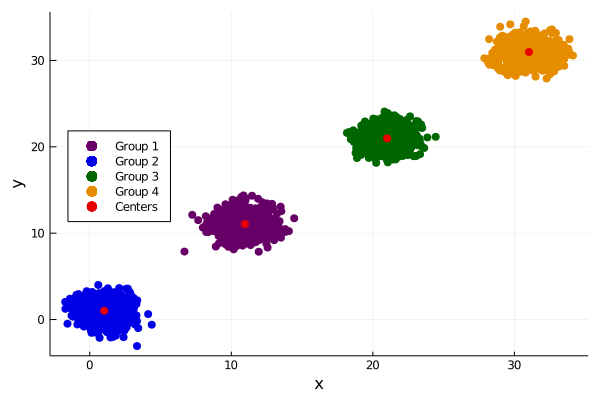

In [84]:
protos = fuzzy_c_means(data, 4, 2, euclidean, 1e-5)
u, _ = find_membership(data, euclidean, protos, [])
plot_clusters(protos, u, data, :left)


Comparing with the given library it is seen that both of them present the same solution.

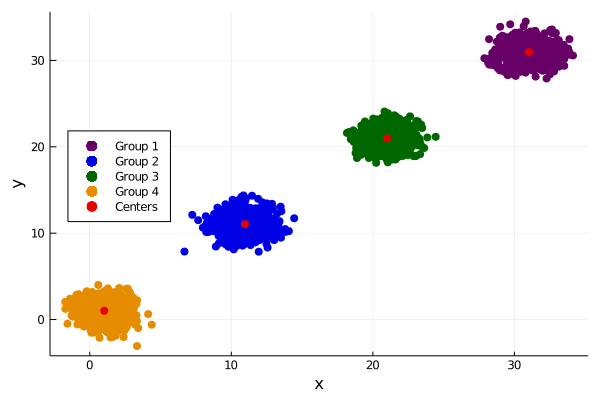

In [176]:
protos_lib = transpose(Clustering.fuzzy_cmeans(transpose(data), 4, 2).centers)
u, _ = find_membership(data, euclidean, protos_lib, [])
plot_clusters(protos_lib, u, data, :left)


**Soft Clustering**

It is important to notice that both algorithms converged to a good solution and
a good number of clusters given the right parameters.


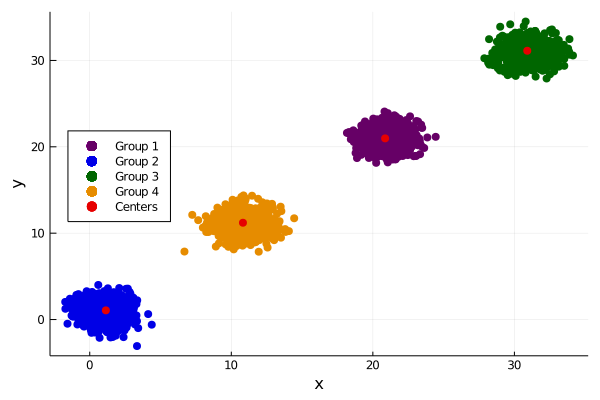

In [85]:
protos = montain_clustering(data, 100, euclidean, 1, 1.5, 0.5, 0.15)
u, _ = find_membership(data, euclidean, protos, [])
plot_clusters(protos, u, data, :left)


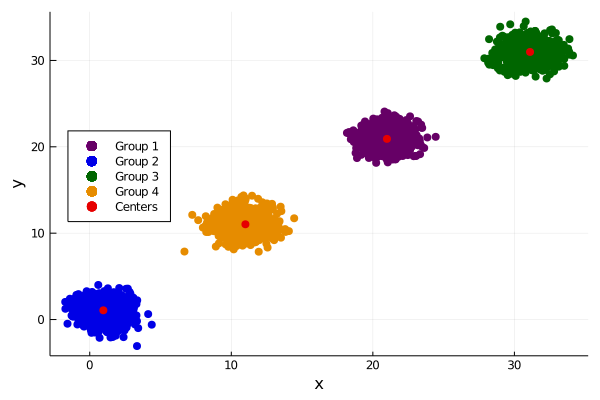

In [86]:
protos = subtractive_clustering(data, euclidean, 2, 3, 0.5, 0.15)
u, _ = find_membership(data, euclidean, protos, [])
plot_clusters(protos, u, data, :left)

## Iris Dataset
For a more complex exercise, the iris dataset was chosen. This data set will
test each of the methods and the results for each triplets will be shown.
Furthermore, a comparison with the already existing methods will be done.

Lastly, the data will be normalized.


In [138]:
iris = normalize(convert(Matrix, dataset("datasets", "iris")[:, 1:4]));


In [127]:
function plot_all_dims(protos, dist, args...)
    u, _ = find_membership(iris, dist, protos, args)
    p1 = plot_clusters3d(protos[:, 1:3], u, iris[:, 1:3], false, (60, 30), "x1", "x2", "x3")
    p2 = plot_clusters3d(protos[:, 2:4], u, iris[:, 2:4], false, (60, 30), "x2", "x3", "x4")
    p3 = plot_clusters3d(protos[:, [1,3,4]], u, iris[:, [1,3,4]], false, (60, 30), "x1", "x3", "x4")
    p4 = plot_clusters3d(protos[:, [1,2,4]], u, iris[:, [1,2,4]], false, (60, 30), "x1", "x2", "x4")

    plot(p1, p2, p3, p4 , layout=4)
end;


**Soft Clustering**

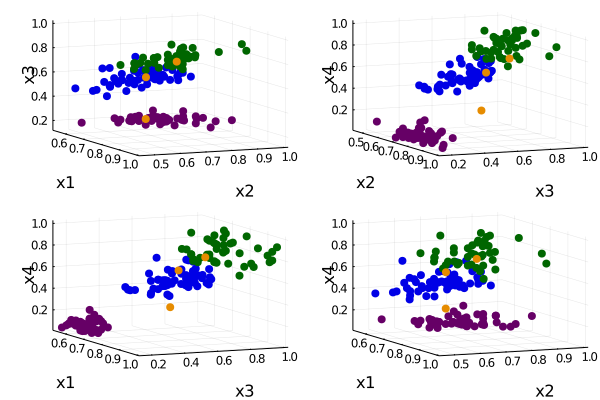

In [189]:
protos = montain_clustering(iris, 25, euclidean, 0.05, 0.15, 0.5, 0.15)
plot_all_dims(protos, euclidean)


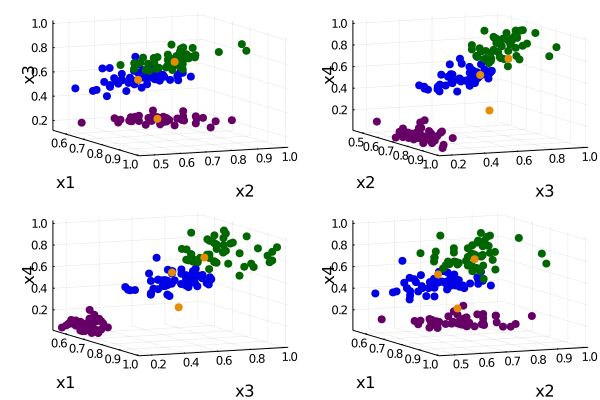

In [190]:
protos = subtractive_clustering(iris, euclidean, 0.1, 0.3, 0.5, 0.15)
plot_all_dims(protos, euclidean)


**K-means**

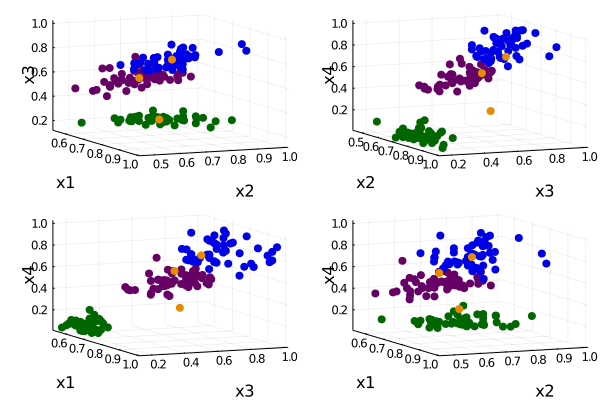

In [191]:
protos, _ = k_means(iris, 3, euclidean, 1e-8);
plot_all_dims(protos, euclidean)


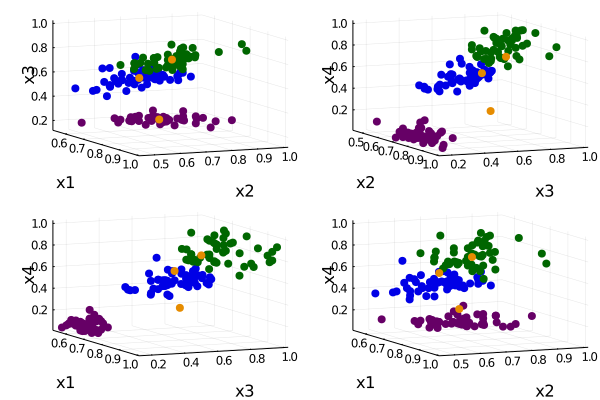

In [192]:
protos_lib = transpose(Clustering.kmeans(transpose(iris), 3).centers)
plot_all_dims(protos_lib, euclidean)


**Fuzzy C-means**

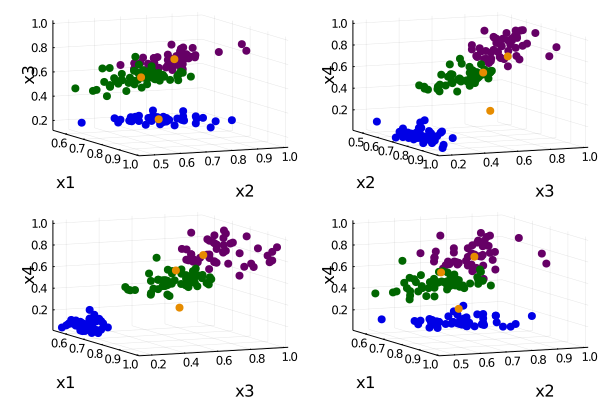

In [145]:
protos = fuzzy_c_means(iris, 3, 2, euclidean, 1e-8);
plot_all_dims(protos, euclidean)
